In [1]:
# pip install pystac-client

In [2]:
# pip install "dask==2023.11.0" "numpy<2.0" "odc-stac>=0.3.6"

In [18]:
from pystac_client import Client

from odc.stac import configure_rio, stac_load

In [19]:
config = {
    "s2_l2a": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "SCL": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
        "aliases": {
            "costal_aerosol": "B01",
            "blue": "B02",
            "green": "B03",
            "red": "B04",
            "red_edge_1": "B05",
            "red_edge_2": "B06",
            "red_edge_3": "B07",
            "nir": "B08",
            "nir_narrow": "B08A",
            "water_vapour": "B09",
            "swir_1": "B11",
            "swir_2": "B12",
            "mask": "SCL",
            "aerosol_optical_thickness": "AOT",
            "scene_average_water_vapour": "WVP",
        },
    }
}

In [20]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

In [21]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [22]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [37.76, 12.49, 37.77, 12.50]

# Set a start and end date
start_date = "2025-01-01"
end_date = "2025-01-31"

# Set the STAC collections
collections = ["s2_l2a"]

In [23]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 6 datasets


In [24]:
crs = "EPSG:6933"
resolution = 10

ds = stac_load(
    items,
    bands=("red","nir"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 293kB
Dimensions:      (y: 125, x: 97, time: 6)
Coordinates:
  * y            (y) float64 1kB 1.582e+06 1.582e+06 ... 1.581e+06 1.581e+06
  * x            (x) float64 776B 3.643e+06 3.643e+06 ... 3.644e+06 3.644e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 48B 2025-01-05T08:06:39 ... 2025-01-30...
Data variables:
    red          (time, y, x) uint16 146kB dask.array<chunksize=(1, 125, 97), meta=np.ndarray>
    nir          (time, y, x) uint16 146kB dask.array<chunksize=(1, 125, 97), meta=np.ndarray>

In [25]:
ds.time

<xarray.DataArray 'time' (time: 6)> Size: 48B
array(['2025-01-05T08:06:39.000000000', '2025-01-10T08:06:35.000000000',
       '2025-01-15T08:06:38.000000000', '2025-01-20T08:06:38.000000000',
       '2025-01-25T08:06:41.000000000', '2025-01-30T08:07:06.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 48B 2025-01-05T08:06:39 ... 2025-01-30...

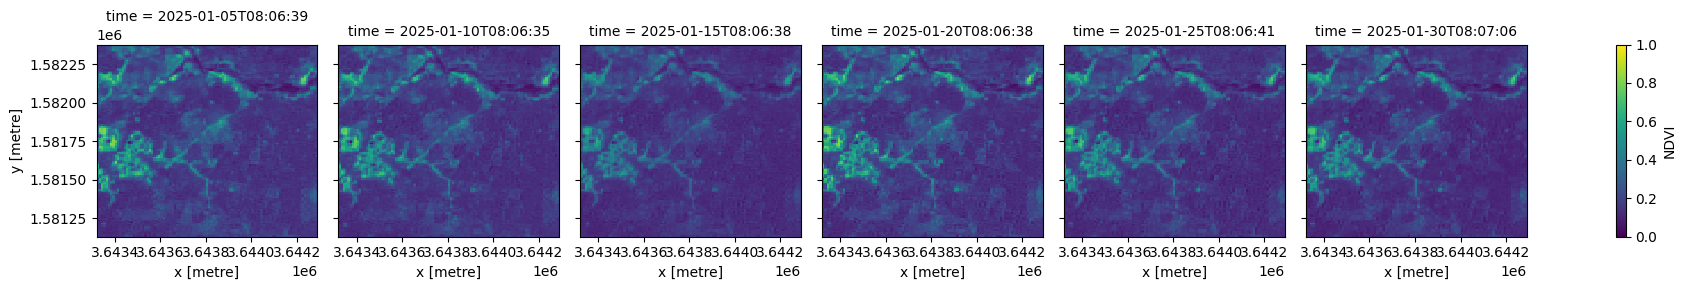

In [26]:
ds["NDVI"] = (ds.nir - ds.red) / (ds.nir + ds.red)

ds.NDVI.compute().plot(col="time", col_wrap=6, vmin=0, vmax=1)

In [40]:
date_from_ds = ds.time.values[3]  # Extract the first time value
date_str = str(date_from_ds)  # Convert the datetime object to string
date_str

'2025-01-20T08:06:38.000000000'

In [28]:
# pip install rioxarray rasterio

In [45]:
%%time
import rasterio
from rasterio.transform import from_origin
import numpy as np

# Get spatial information from your dataset
y = ds.coords["y"].values
x = ds.coords["x"].values

# Create a transform for the raster
transform = from_origin(x.min(), y.max(), abs(x[1] - x[0]), abs(y[1] - y[0]))

# Define the firm ID (you can modify this as needed)
firm_id = "id034"  # Replace with actual firm ID

# Define the variable name (NDVI in this case)
variable = "NDVI"

# Loop through all time slices
for idx, time_val in enumerate(ds.time.values):
    # Extract NDVI for the current time slice
    ndvi = ds["NDVI"].values[idx]  # Select the NDVI values for the current time slice

    # Extract the date from the current time slice
    date_str = str(time_val).split("T")[0]  # Convert to string and keep only the date part (YYYY-MM-DD)

    # Define the output file path based on the naming convention
    output_file = f"{firm_id}_{date_str}_{variable}.tiff"

    # Open a rasterio dataset for writing
    with rasterio.open(
        output_file, 
        'w', 
        driver='GTiff', 
        height=ndvi.shape[0], 
        width=ndvi.shape[1], 
        count=1, 
        dtype=ndvi.dtype, 
        crs="EPSG:6933",  # Using the CRS code you provided
        transform=transform
    ) as dst:
        # Write the NDVI data to the .tiff file
        dst.write(ndvi, 1)

    print(f"NDVI band for {date_str} saved as {output_file}")

NDVI band for 2025-01-05 saved as id034_2025-01-05_NDVI.tiff
NDVI band for 2025-01-10 saved as id034_2025-01-10_NDVI.tiff
NDVI band for 2025-01-15 saved as id034_2025-01-15_NDVI.tiff
NDVI band for 2025-01-20 saved as id034_2025-01-20_NDVI.tiff
NDVI band for 2025-01-25 saved as id034_2025-01-25_NDVI.tiff
NDVI band for 2025-01-30 saved as id034_2025-01-30_NDVI.tiff
CPU times: total: 3.81 s
Wall time: 7.42 s
